In [1]:
from qiskit import *
from math import *
import numpy as np

%matplotlib inline

# N is the number you want to be factored
N = 15
# x should be copime to N
# numberOfQubits, q, has to be N**2 < Q < 2N**2 where Q = 2**q
n = int(np.ceil(log(N, 2)))

qubits = []

In [2]:
def get_a_Value(N):
    ok = '0'
    a = 2
    while gcd(a,N)!=1:
        a = a + 1
    smallest_a = a
    return a
a = get_a_Value(21)
print("The smallest value found coprime to N is: " + str(a))

The smallest value found coprime to N is: 2


In [3]:
aux = QuantumRegister(n + 2)
up_reg = QuantumRegister(1)
down_reg = QuantumRegister(n)

aux_classic = ClassicalRegister(n + 2)
up_classic = ClassicalRegister(1)
down_classic = ClassicalRegister(n)

circuit = QuantumCircuit(down_reg , up_reg , aux, down_classic, up_classic, aux_classic)

circuit.h(up_reg)
circuit.x(down_reg[1])
circuit.barrier()

In [4]:
def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)
    
def modinv(a, m):
    g, x, y = egcd(a, m)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % m

"""Function that calculates the array of angles to be used in the addition in Fourier Space"""
def getAngles(a,N):
    s=bin(int(a))[2:].zfill(N) 
    angles=np.zeros([N])
    for i in range(0, N):
        for j in range(i,N):
            if s[j]=='1':
                angles[N-i-1]+=pow(2, -(j-i))
        angles[N-i-1]*=pi
    return angles


"""Creation of a doubly controlled phase gate"""
def ccphase(circuit,angle,ctl1,ctl2,tgt):
    circuit.cu1(angle/2,ctl1,tgt)
    circuit.cx(ctl2,ctl1)
    circuit.cu1(-angle/2,ctl1,tgt)
    circuit.cx(ctl2,ctl1)
    circuit.cu1(angle/2,ctl2,tgt)

"""Creation of the circuit that performs addition by a in Fourier Space"""
"""Can also be used for subtraction by setting the parameter inv to a value different from 0"""
def phiADD(circuit,q,a,N,inv):
    angle=getAngles(a,N)
    for i in range(0,N):
        if inv==0:
            circuit.u1(angle[i],q[i])
        else:
            circuit.u1(-angle[i],q[i])

"""Single controlled version of the phiADD circuit"""
def cphiADD(circuit,q,ctl,a,n,inv):
    angle=getAngles(a,n)
    for i in range(0,n):
        if inv==0:
            circuit.cu1(angle[i],ctl,q[i])
        else:
            circuit.cu1(-angle[i],ctl,q[i])
        
"""Doubly controlled version of the phiADD circuit""" 
def ccphiADD(circuit,q,ctl1,ctl2,a,n,inv):
    angle=getAngles(a,n)
    for i in range(0,n):
        if inv==0:
            ccphase(circuit,angle[i],ctl1,ctl2,q[i])
        else:
            ccphase(circuit,-angle[i],ctl1,ctl2,q[i])

"""Circuit that implements doubly controlled modular addition by a"""        
def ccphiADDmodN(circuit, q, ctl1, ctl2, aux, a, N, n):
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
    phiADD(circuit, q, N, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.cx(q[n-1],aux)
    create_QFT(circuit,q,n,0)
    cphiADD(circuit, q, aux, N, n, 0)
    
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.x(q[n-1])
    circuit.cx(q[n-1], aux)
    circuit.x(q[n-1])
    create_QFT(circuit,q,n,0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)  
    
"""Circuit that implements the inverse of doubly controlled modular addition by a"""
def ccphiADDmodN_inv(circuit, q, ctl1, ctl2, aux, a, N, n):
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.x(q[n-1])
    circuit.cx(q[n-1],aux)
    circuit.x(q[n-1])
    create_QFT(circuit, q, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
    cphiADD(circuit, q, aux, N, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.cx(q[n-1], aux)
    create_QFT(circuit, q, n, 0)
    phiADD(circuit, q, N, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
    
"""Circuit that implements single controlled modular multiplication by a"""
def cMULTmodN(circuit, ctl, q, aux, a, N, n):
    create_QFT(circuit,aux,n+1,0)
    for i in range(0, n):
        ccphiADDmodN(circuit, aux, q[i], ctl, aux[n+1], (2**i)*a % N, N, n+1)
    create_inverse_QFT(circuit, aux, n+1, 0)

    for i in range(0, n):
        circuit.cswap(ctl,q[i],aux[i])

    a_inv = modinv(a, N)
    create_QFT(circuit, aux, n+1, 0)
    i = n-1
    while i >= 0:
        ccphiADDmodN_inv(circuit, aux, q[i], ctl, aux[n+1], pow(2,i)*a_inv % N, N, n+1)
        i -= 1
    create_inverse_QFT(circuit, aux, n+1, 0)
    

""" Function to create QFT """
def create_QFT(circuit,up_reg,n,with_swaps):
    i=n-1
    """ Apply the H gates and Cphases"""
    """ The Cphases with |angle| < threshold are not created because they do 
    nothing. The threshold is put as being 0 so all CPhases are created,
    but the clause is there so if wanted just need to change the 0 of the
    if-clause to the desired value """
    while i>=0:
        circuit.h(up_reg[i])        
        j=i-1  
        while j>=0:
            if (pi)/(pow(2,(i-j))) > 0:
                circuit.cu1( (pi)/(pow(2,(i-j))) , up_reg[i] , up_reg[j] )
                j=j-1   
        circuit.barrier()
        i=i-1  

    """ If specified, apply the Swaps at the end """
    if with_swaps==1:
        i=0
        while i < ((n-1)/2):
            circuit.swap(up_reg[i], up_reg[n-1-i])
            i=i+1
        circuit.barrier()

""" Function to create inverse QFT """
def create_inverse_QFT(circuit,up_reg,n,with_swaps):
    """ If specified, apply the Swaps at the beggining"""
    if with_swaps==1:
        i=0
        while i < ((n-1)/2):
            circuit.swap(up_reg[i], up_reg[n-1-i])
            i=i+1
        circuit.barrier()
    
    """ Apply the H gates and Cphases"""
    """ The Cphases with |angle| < threshold are not created because they do 
    nothing. The threshold is put as being 0 so all CPhases are created,
    but the clause is there so if wanted just need to change the 0 of the
    if-clause to the desired value """
    i=0
    while i<n:
        circuit.h(up_reg[i])
        if i != n-1:
            j=i+1
            y=i
            while y>=0:
                 if (np.pi)/(pow(2,(j-y))) > 0:
                    circuit.cu1( - (pi)/(pow(2,(j-y))) , up_reg[j] , up_reg[y] )
                    y=y-1
            circuit.barrier()
        i=i+1

"""def qft(circ, n):
    # Don't forget the Swaps!
    for j in range(0,n):
        for m in range(j):
            circ.cu1(pi/float(2**(j-m)), m, j)
        circ.barrier()
        circ.h(j)
    for qubit in range(int(n/2)):
        circ.swap(qubit, n-qubit-1)
    circ.barrier()
    
def qft_dagger(circ, n):
    # Don't forget the Swaps!
    for j in range(0,n):
        for m in range(j):
            circ.cu1(-pi/float(2**(j-m)), m, j)
        circ.barrier()
        circ.h(j)
    for qubit in range(int(n/2)):
        circ.swap(qubit, n-qubit-1)
    circ.barrier()"""

"def qft(circ, n):\n    # Don't forget the Swaps!\n    for j in range(0,n):\n        for m in range(j):\n            circ.cu1(pi/float(2**(j-m)), m, j)\n        circ.barrier()\n        circ.h(j)\n    for qubit in range(int(n/2)):\n        circ.swap(qubit, n-qubit-1)\n    circ.barrier()\n    \ndef qft_dagger(circ, n):\n    # Don't forget the Swaps!\n    for j in range(0,n):\n        for m in range(j):\n            circ.cu1(-pi/float(2**(j-m)), m, j)\n        circ.barrier()\n        circ.h(j)\n    for qubit in range(int(n/2)):\n        circ.swap(qubit, n-qubit-1)\n    circ.barrier()"

In [5]:
"""def qubitList(numberOfQubits):
    for i in range(numberOfQubits):
        qubits.append(i)
    print(qubits)
    return qubits

def shorsFunction(qubits, x, N):
    periodicFunction = []
    for i in range(len(qubits)):
        y = (x ** i) % N
        periodicFunction.append(y)
    print(periodicFunction)
    return periodicFunction

qubitList(n)
shorsFunction(qubits, x, N)"""


'def qubitList(numberOfQubits):\n    for i in range(numberOfQubits):\n        qubits.append(i)\n    print(qubits)\n    return qubits\n\ndef shorsFunction(qubits, x, N):\n    periodicFunction = []\n    for i in range(len(qubits)):\n        y = (x ** i) % N\n        periodicFunction.append(y)\n    print(periodicFunction)\n    return periodicFunction\n\nqubitList(n)\nshorsFunction(qubits, x, N)'

In [6]:
cMULTmodN(circuit, up_reg[0], down_reg, aux, int(a), N, n)

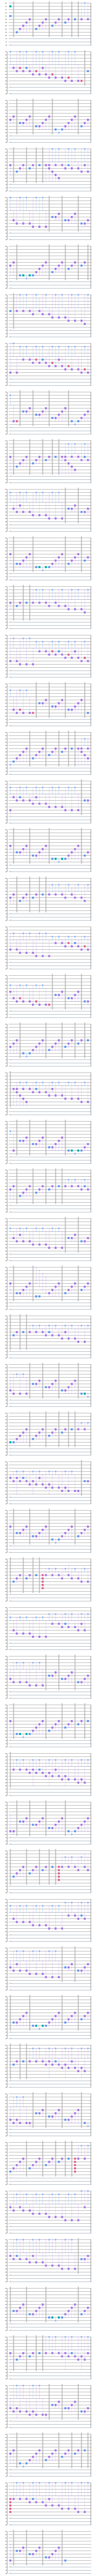

In [7]:
circuit.draw('mpl')

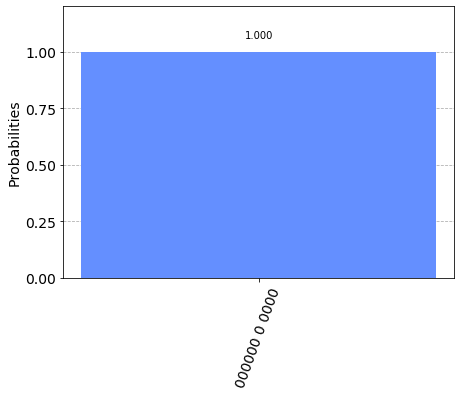

In [9]:
for k in range(n):
    circuit.measure(10, 10)

simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator, shots = 10000).result()
counts = result.get_counts(circuit)
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

In [ ]:
print(counts)